# Demo of graph optimisation on real graph to segment structures:

# TODO: implement edge classification predictions just as in the dummy graph:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from scipy.special import softmax


In [3]:
import torch

In [4]:
from grace.base import GraphAttrs
from grace.simulate import random_graph, random_graph_mixed_motifs
from grace.models.datasets import dataset_from_graph
from grace.models.optimise import optimise_graph


### Load a dummy graph:

In [72]:
G = random_graph(n_motifs=5, n_chaff=100, scale=1.0, density=0.075, motif="line")

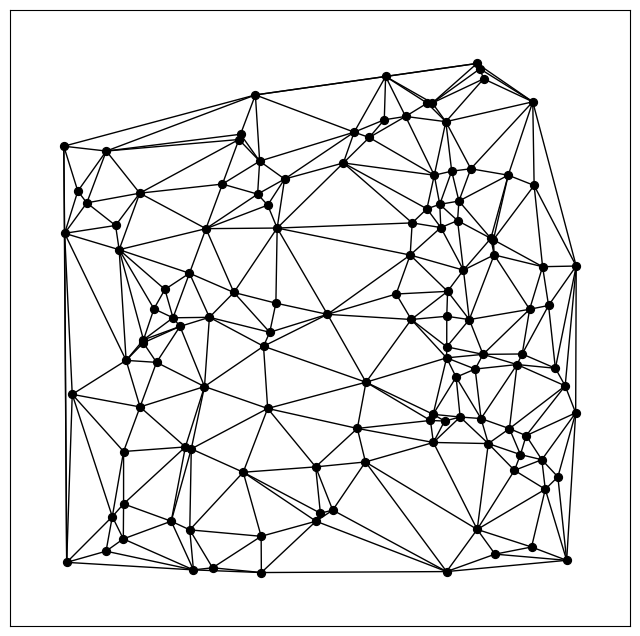

In [74]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in G.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(G, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

### Understand how the edge weights are distributed:

In [75]:
def plot_node_and_edge_label_distribution(graph: nx.Graph, attr: str = "hello") -> None: 

    node_labels = [node[GraphAttrs.NODE_GROUND_TRUTH] for _, node in graph.nodes(data=True)]
    plt.hist(node_labels, label=f"GT nodes: {sum(node_labels)} / {len(node_labels)}")
    plt.legend()
    plt.show()



In [76]:
plot_node_and_edge_label_distribution(graph=G)

KeyError: <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>

### Load the pre-trained models for node & edge classification:

In [77]:
model_nodes = torch.load("../../data/gcn/model_nodes.pt")
model_edges = torch.load("../../data/gcn/model_edges.pt")
model_nodes, model_edges

(GCN(
   (conv1): GCNConv(3, 64)
   (conv2): GCNConv(64, 64)
   (conv3): GCNConv(64, 64)
   (linear): Linear(in_features=64, out_features=2, bias=True)
 ),
 GCN(
   (conv1): GCNConv(2048, 64)
   (conv2): GCNConv(64, 64)
   (conv3): GCNConv(64, 64)
   (linear): Linear(in_features=64, out_features=2, bias=True)
 ))

In [78]:
def get_node_predictions(G, model):
    model.eval()

    predictions = []
    dataset = dataset_from_graph(G)

    for data in dataset:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        probs = softmax(out.detach().numpy())

        predictions.append((int(pred.numpy()), probs))

    # this is the prediction that the node is in the object
    for (_, node), pred in zip(G.nodes.data(), predictions):
        # for a FP, we want this to be the prob that it's *NOT* in the object
        # print(pred)
        node[GraphAttrs.NODE_PREDICTION] = np.clip(float(pred[1][0, 0]), 0, 1)

    return G

In [79]:
def get_edge_predictions(G, model):
    # TODO
    pass

In [80]:
# get_node_predictions(G, model_nodes)
# get_edge_predictions(G, model_edges)

### Optimise the dummy graph:

In [81]:
# NOTE(arl): this is *super* hacky - just to see if the optimisation works

def update_graph_dummy(G):

    # G = get_predictions(G, model)

    nodes = list(G.nodes.data())

    for _, node in nodes:
        pd = np.random.random()*0.5
        if node["label"] > 0:
            node[GraphAttrs.NODE_PREDICTION] = pd
        else:
            node[GraphAttrs.NODE_PREDICTION] = 1-pd

    
    for edge in G.edges.data():
        pd = np.random.random()*0.1
        _, e_i = nodes[edge[0]]
        _, e_j = nodes[edge[1]]
        
        if e_i["object_idx"] == e_j["object_idx"] and e_i["label"] > 0:
            edge[2][GraphAttrs.EDGE_PREDICTION] = 1 - pd
        else:
            edge[2][GraphAttrs.EDGE_PREDICTION] = pd 


In [82]:
update_graph_dummy(G)


(array([ 3.,  0.,  3.,  3.,  6.,  4.,  4.,  1.,  0.,  2., 12., 16., 11.,
        11.,  9.,  7.,  7., 10., 11.,  6.]),
 array([0.00579444, 0.055498  , 0.10520156, 0.15490512, 0.20460868,
        0.25431223, 0.30401579, 0.35371935, 0.40342291, 0.45312647,
        0.50283002, 0.55253358, 0.60223714, 0.6519407 , 0.70164426,
        0.75134782, 0.80105137, 0.85075493, 0.90045849, 0.95016205,
        0.99986561]),
 <BarContainer object of 20 artists>)

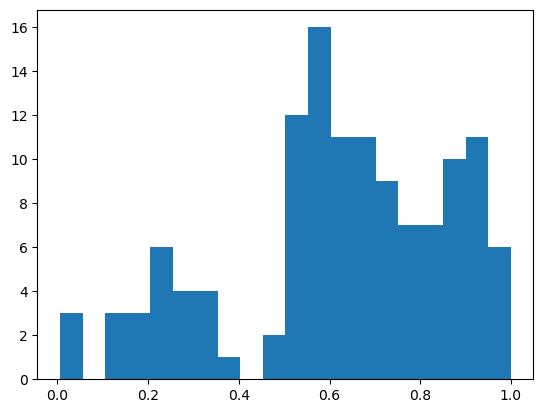

In [83]:
node_labels = [node[GraphAttrs.NODE_PREDICTION] for _, node in G.nodes(data=True)]
plt.hist(node_labels, bins=20)


(array([17., 12.,  5.,  5.,  9.,  6.,  6., 13., 13., 14.]),
 array([0.00052705, 0.05036135, 0.10019565, 0.15002995, 0.19986425,
        0.24969856, 0.29953286, 0.34936716, 0.39920146, 0.44903576,
        0.49887006]),
 <BarContainer object of 10 artists>)

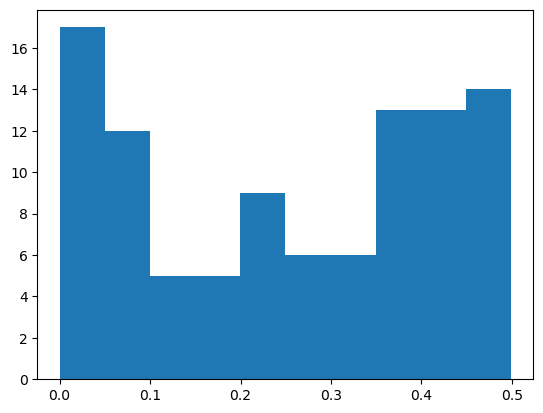

In [84]:
n = [np.random.random()*0.5 for _ in range(100)]
plt.hist(n)

In [85]:
node_labels = [node['label'] for _, node in G.nodes(data=True)]
node_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [86]:
x = optimise_graph(G)

### Visualise the graph & individual objects:

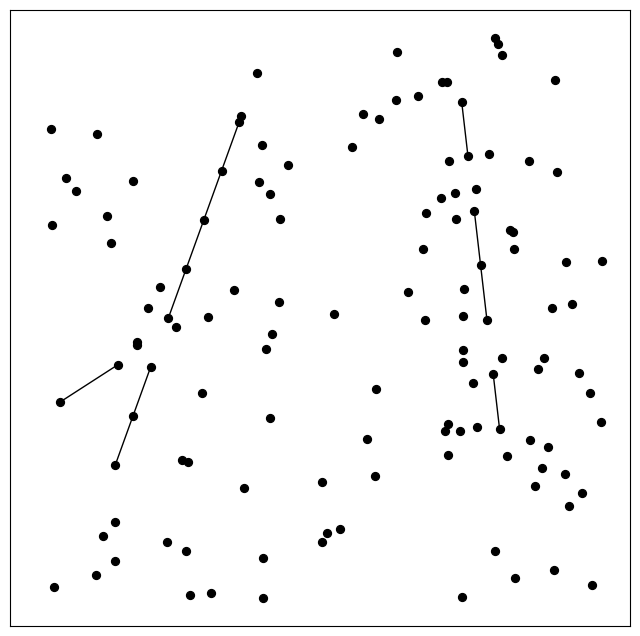

In [87]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)
plt.show()

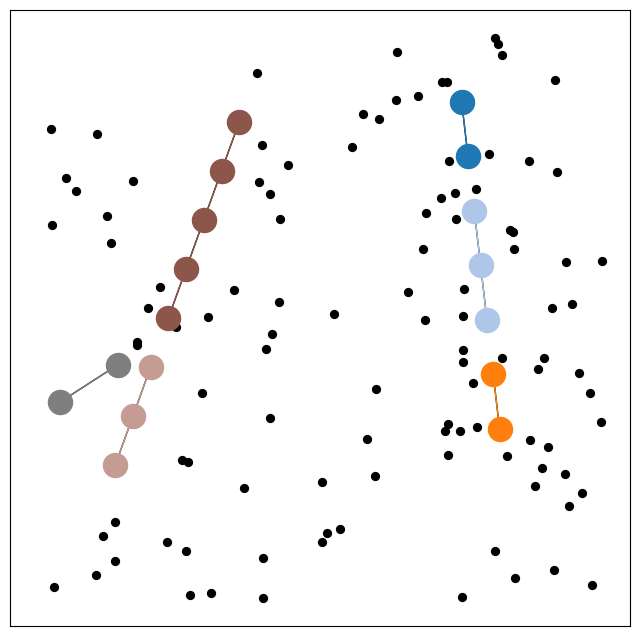

In [88]:

# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    # print (index, sg)

    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

plt.show()

## TODO: implement on real graph data!

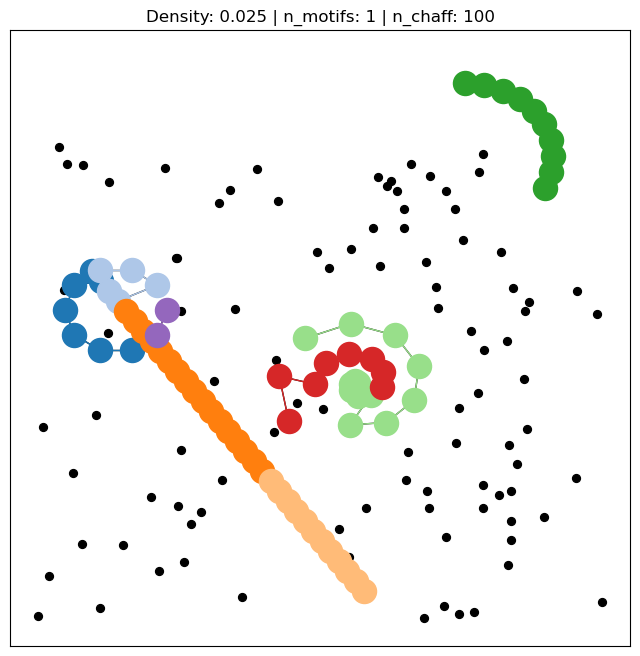

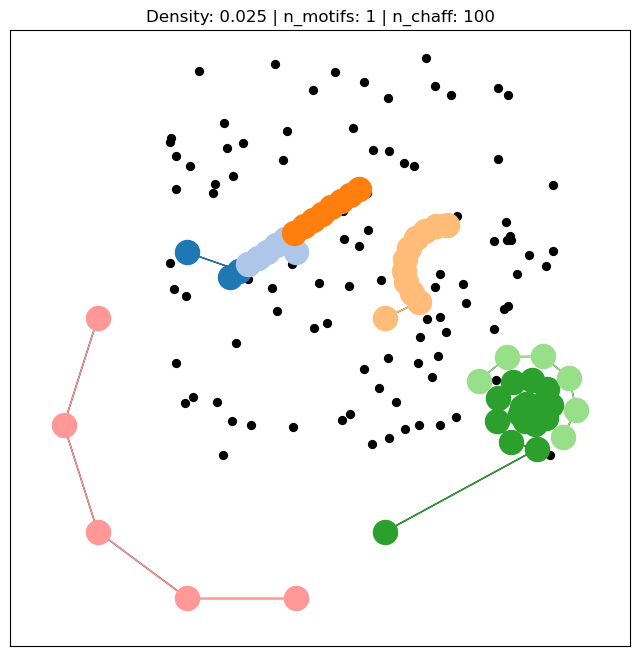

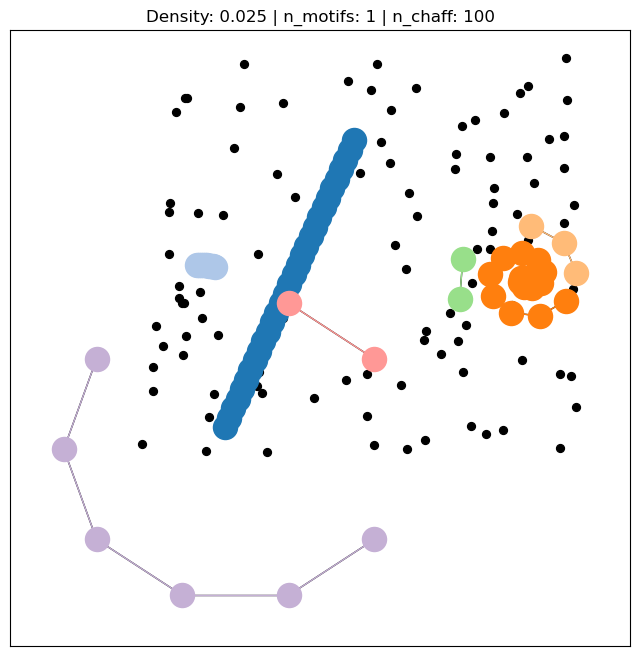

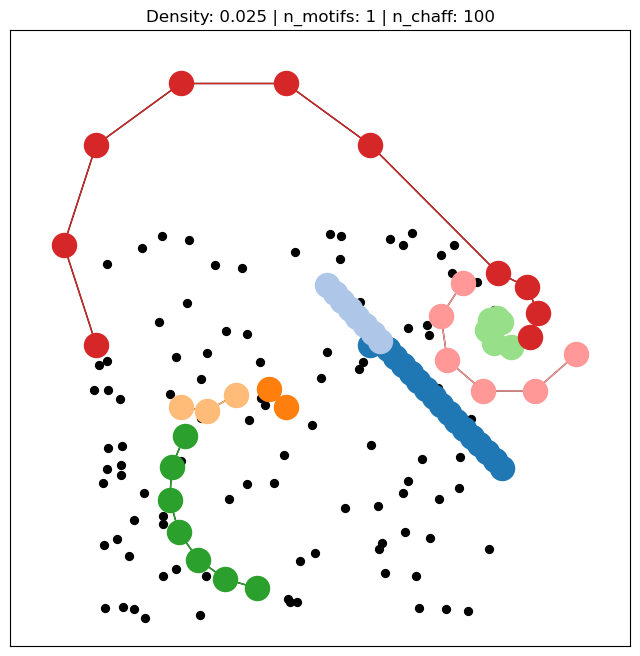

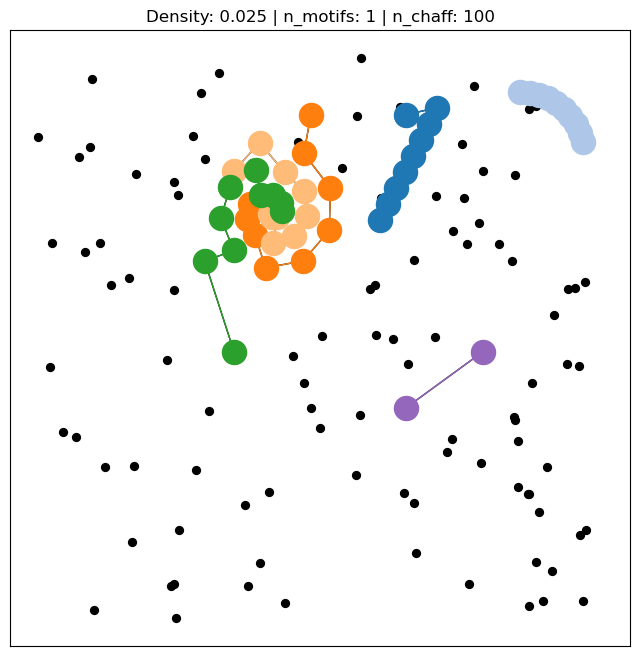

In [13]:
num_trials = 5
density = 0.025
n_motifs = 1
n_chaff = 100

for i in range(num_trials):
    # G = random_graph(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    G = random_graph_mixed_motifs(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    update_graph_dummy(G)
    x = optimise_graph(G)
    
    # Plot:
    # plt.ion()

    pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
    fig, ax = plt.subplots(figsize=(8, 8))

    # draw all nodes/vertices in the graph, including those not determined to be 
    # part of the objects
    nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

    # get each connected subgraph and draw it with a different colour
    cc = nx.connected_components(x)
    for index, sg in enumerate(cc):
        
        if len(sg) <= 1:
            continue

        c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
        sg = x.subgraph(sg).copy()
        plt.title(f"Density: {density} | n_motifs: {n_motifs} | n_chaff: {n_chaff}")
        nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

    plt.show()